In [1]:
import numpy as np

# generate the Gaussian 5x5 kernel
# sigma = 1
def gaussian_kernel(size, sigma=1.4):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    N = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * N
    return g

In [2]:
from scipy import ndimage

# Below is how the Sobel filters are applied to the image, and how to get both intensity and edge direction matrices
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [3]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [4]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [5]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')
%matplotlib inline

Mounted at /content/drive


In [14]:
img =Image.open("https://drive.google.com/file/d/1C2zUY44a0mDluc4y3WEnRD-NkrQaJ-MI/view?usp=sharing", "rb").read()

ValueError: ignored

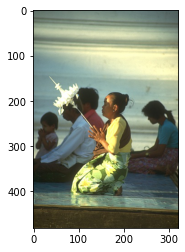

In [ ]:
plt.imshow(img)

In [ ]:
print(img.size)
print(img.mode)
print(img.format)

(321, 481)
RGB
JPEG


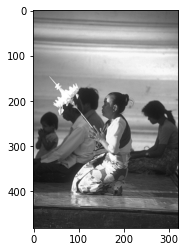

In [ ]:
G_img = img.convert('L')
plt.imshow(G_img, cmap ='gray')

In [ ]:
size = 5*5

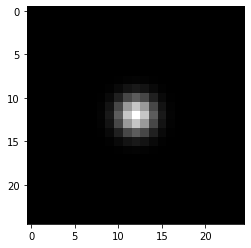

In [ ]:
G_op = gaussian_kernel(size, sigma=1.4)
plt.imshow(G_op, cmap ='gray')

In [ ]:
sobel_filters(G_img)

(array([[134.8  ,  81.3  , 108.06 , ...,  13.6  ,  68.06 ,  72.25 ],
        [134.5  ,  97.56 , 139.6  , ..., 180.4  ,  39.47 ,  64.6  ],
        [112.6  ,  81.94 , 158.5  , ..., 176.1  ,   5.836,  15.625],
        ...,
        [219.8  , 229.8  , 156.   , ..., 150.5  , 148.4  , 163.8  ],
        [185.   , 177.4  , 215.4  , ..., 145.9  , 142.8  , 169.1  ],
        [208.2  , 169.9  , 189.   , ..., 180.9  , 180.4  , 173.4  ]],
       dtype=float16),
 array([[0.3484  , 0.5493  , 0.2512  , ..., 0.1566  , 0.2954  , 0.702   ],
        [0.452   , 0.6826  , 0.3088  , ..., 1.543   , 0.633   , 1.166   ],
        [0.1703  , 0.289   , 0.0939  , ..., 1.566   , 0.245   , 1.48    ],
        ...,
        [0.662   , 0.8594  , 0.2241  , ..., 0.9253  , 1.122   , 1.458   ],
        [0.644   , 0.9497  , 0.9297  , ..., 0.8955  , 1.406   , 1.559   ],
        [0.8335  , 1.048   , 0.8916  , ..., 1.165   , 1.559   , 0.012245]],
       dtype=float16))

In [ ]:
non_max_suppression(img, D)

NameError: name 'D' is not defined